# Logistic Regression

This logistic regression is based on the Beeler/Daw et al. 2010 paper.
Specifically:

dependent variable: binary choice of port (-1 or 1)

explanatory variables: 
1. the N previous rewards $ r_{t-N:t-1} $
2. the previous choice $c_{t-1}$ to capture a tendency to stay or switch
3. bias variable (1) to capture fixed, overall preference for either port

Note: this model only carries information about ports when it gets a reward. IE -1 = right reward, 1 = left reward, but 0 = no reward (for either side). Should compare models with this information vs. added information about the non-rewarded port choices. 

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
import sklearn.tree
%matplotlib inline 

## Load in trial data and convert into feature dataframe

In [2]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_7030_02192017.csv',index_col=0)
data.shape

(17856, 50)

## Make Right port == -1 instead of 0

In [60]:
port_features = []
reward_features = []

#change right port to -1 instead of 0
for col in data:
    if '_Port' in col:
        data.loc[data[col] == 0,col] = -1
        port_features.append(col)
    elif '_Reward' in col:
        reward_features.append(col)

#change decision = 0 to decision = -1
#data.loc[data['Decision'] == 0,'Decision'] = -1
        
#we want to combine the actions and outcomes into a single feature
#where -1 is a reward on the right, 0 is no reward, and 1 is a reward on the left

#create new feature matrix
data_new = data.copy()
for i in range(len(port_features)):
    data_new[reward_features[i]] = data[reward_features[i]].values*data[port_features[i]].values

features = reward_features.copy()
features.append('1_Port')
features.append('Decision')

data_old = data.copy()
data = data_new[features].copy()

## split data into training and testing sets (70 - 30)

In [4]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

## fit logistic regression

In [5]:
logreg = sklearn.linear_model.LogisticRegressionCV()
logreg.fit(x_train,y_train)
y_predict = logreg.predict(x_test)
y_predict_proba = logreg.predict_proba(x_test)

## evaluate the model

In [6]:
score = logreg.score(x_test,y_test)
print('Classification accuracy: %.02f' % score)

Classification accuracy: 0.91


In `Beeler et al 2010` they used a pseudo-$r^2$ statistic defined as:

(R-L)/R

Where:
    - R is negative log likelihood of the data under random chance (the # of choices multiplied by -log(0.5)
    - L is negative log likelihood of the data under the model
    
According to [statsmodels](http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.discrete.discrete_model.LogitResults.html) this looks like it's equivalent to McFadden's pseudo-R-squared statistic. 



In [7]:
from statsmodels.discrete.discrete_model import Logit

model = Logit(y_train,x_train)
rslt  = model.fit()

print("Negative Log likelihood of the data under the model : %.02f" % (-1*rslt.llf))
print("\nMcFadden's pseudo-R-squared statistic: %.02f" % rslt.prsquared)

Optimization terminated successfully.
         Current function value: 0.236131
         Iterations 8
Negative Log likelihood of the data under the model : 2951.41

McFadden's pseudo-R-squared statistic: 0.66


For comparison, Beeler reported a negative log likelihood of 116,800 and a pseudo-R-squared statistic 0.83 for a comparable logistic regression model (actually their's took 20 decisions into the past).

So I'm getting a much smaller negative log likelihood, and a somewhat smaller pseudo-R-squared.

## Regression Coefficients

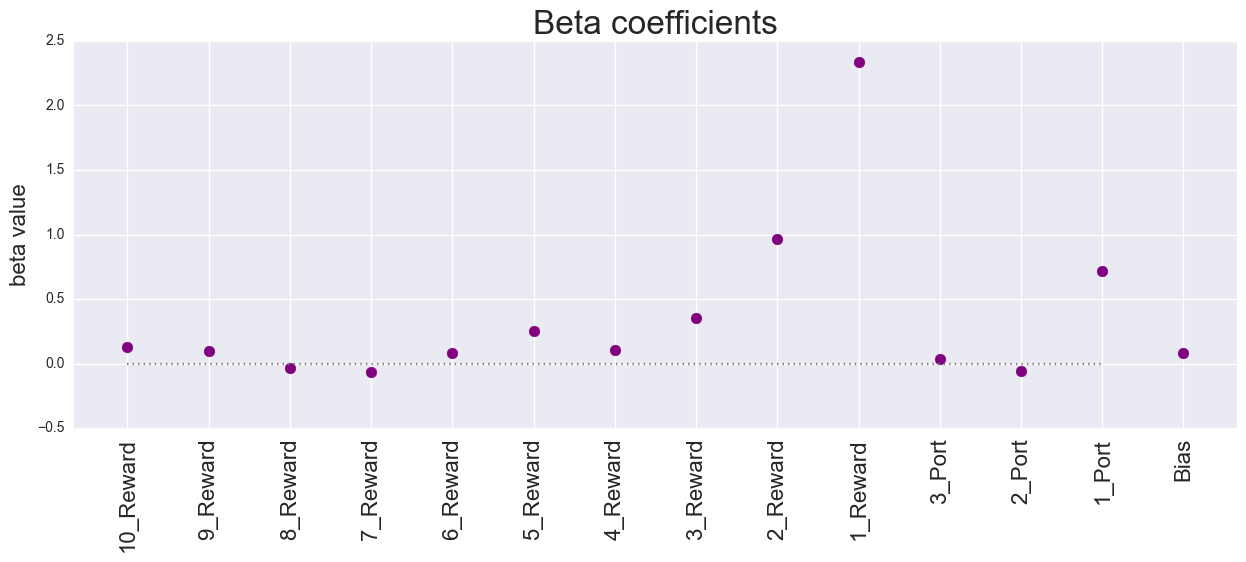

In [8]:
coefs = logreg.coef_ #retrieve coefs
coefs = np.append(coefs[0],logreg.intercept_) #add bias coef

'''
plot
'''
plt.figure(figsize=(15,5))
plt.scatter(np.arange(coefs.shape[0]),coefs,color='purple',s=60)
plt.xticks(np.arange(coefs.shape[0]),features[:-1] + ['Bias'],rotation='vertical',fontsize=16)
plt.hlines(y=0,xmin=0,xmax=12,color='grey',linestyles='dotted')
plt.ylabel('beta value',fontsize=16)
plt.title('Beta coefficients',fontsize=24)

## Did the model get the switches right?

In [9]:
#calc true switches
y_test_switch = np.abs(np.diff(y_test))

#calc model switches
y_predict_switch = np.abs(np.diff(y_predict))

In [10]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False)

          Predicted NO  Predicted YES
True NO         2276.0          457.0
True YES         474.0         2149.0

F1: 0.822

Accuracy on class 0: 0.83
Accuracy on class 1: 0.82



# Compare across 90-10,80-20,70-30 conditions

([<matplotlib.axis.YTick at 0x1109433c8>,
 <a list of 3 Text yticklabel objects>)

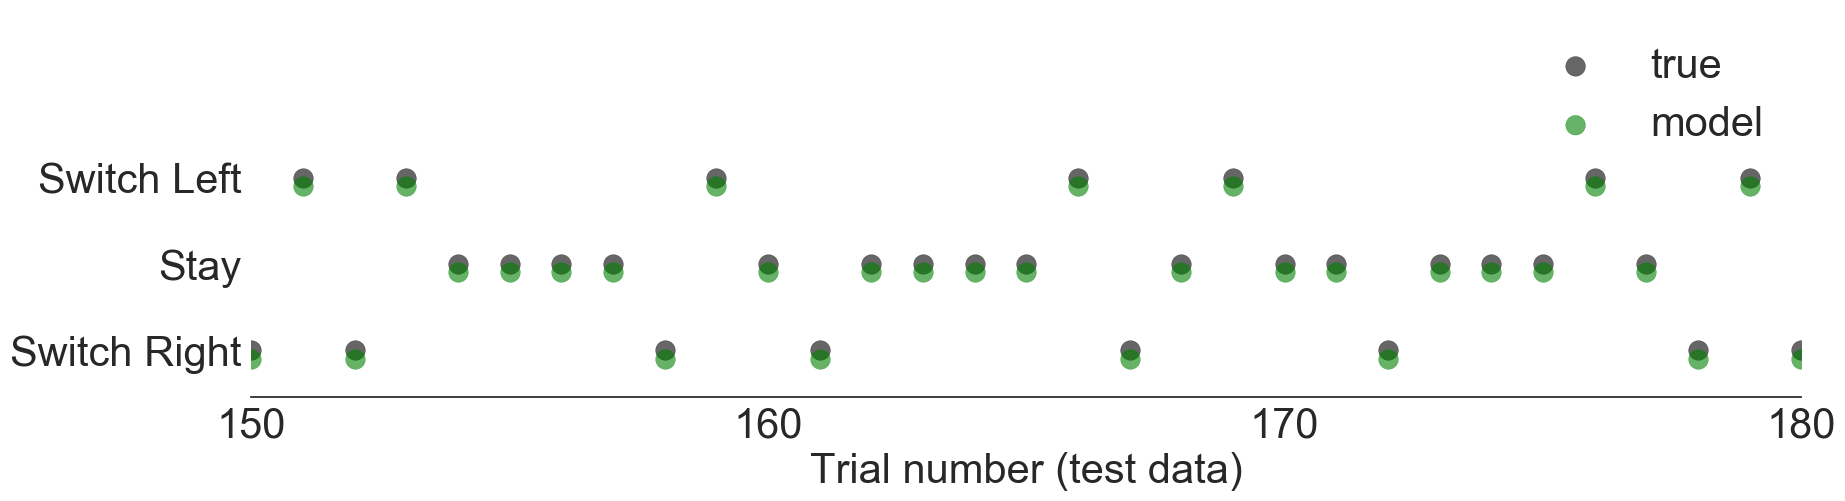

In [11]:
y_switch_true = np.diff(y_test)
y_switch_model = np.diff(y_predict)
sns.set_style('white')

plt.figure(figsize=(20,5))
plt.scatter(np.arange(y_switch_true.shape[0]),y_switch_true+0.05,color='black',label='true',alpha=0.6,s=200)
plt.scatter(np.arange(y_switch_model.shape[0]),y_switch_model-0.05,color='green',label='model',alpha=0.6,s=200)
sns.despine(left=True,bottom=False)
plt.legend(loc='best',fontsize=30)
plt.xlim(350,380)
plt.xticks([350,360,370,380],[150,160,170,180],fontsize=30)
plt.ylim(-1.5,3)
plt.xlabel('Trial number (test data)',fontsize=30)
plt.yticks([-1,0,1],['Switch Right','Stay','Switch Left'],fontsize=30)

## 02/19/2017
I just ran the above code on the following data:
    
- `full_9010_02192017.csv`
- `full_8020_02192017.csv`
- `full_7030_02192017.csv`

Which were computed by compiling the following data:
- block range: exactly 50 rewards
- p(choose high Port) >= [p-0.1] where p = p(high Port)

Observations:
1. F1 for each condition pretty similar. ~0.82-0.85
2. pseudo-R2 also similar: ~0.64-0.69
3. For (1) and (2) maybe a slight trend that 90-10 had a better model, but not certain. 
4. For each condition, I tried adding in more ports (up to 3) into the past to see if it would help out. For all 3 conditions, decisions for t-N where 2 >= 2 had coefficients = 0. That is, the only non-zero beta for the ports was the most recent one. 

Next step: 


**Figures**

1. Logistic regression performs similarly across different conditions
    - x axis: 90-10,80-20,70-30
    - y axis: F1 score, pseudo-R2
2. Comparing model flexibility across different conditions
    - x axis: number of previous rewards included (i.e. parameters in model)
    - y axis: BIC
    - color: each condition
3. Knowing where the non-rewarded trials are:
    - what if you did the same regression, but instead you know where the non-rewarded trials are?
    - also, compare to adding in previous ports (or rewards in the above scenario) and compare

4. Comparing 'strategies' across conditions
    - train on 90-10, test on 80-20 (and all combinations)

5. Comparing 'strategies' across mice
    - train on one mouse:condition pair, and test on another mouse:condition pair (for the same condition)
   
### This is being done in a new notebook:  [`LogReg_Analyses`](http://localhost:8888/notebooks/jupyter_notebooks/Modeling_Behavior/LogReg_Analyses.ipynb#)


In [64]:
features[-1*(5+2):]

['5_Reward',
 '4_Reward',
 '3_Reward',
 '2_Reward',
 '1_Reward',
 '1_Port',
 'Decision']

In [57]:
features = features[1:].append('Bias')
pd.DataFrame(data=coefs.reshape(1,-1),columns=features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.131236,0.098359,-0.033004,-0.064637,0.080823,0.252127,0.106035,0.352404,0.967932,2.33546,0.03277,-0.055856,0.717203,0.080604
